In [ ]:
from google.colab import drive
drive.mount('/content/drive2',force_remount=True)

Mounted at /content/drive2


In [ ]:
# install stop_words if not installed
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32919 sha256=7ac97bcf68e95aec63013f8b87a270a62174e45f6d1a0ae3ddf807bdd0e205e4
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [ ]:
import pandas as pd
import numpy as np
from stop_words import get_stop_words # could be deleted
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import sklearn.model_selection
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
import re
import time

In [ ]:
global all_stop_words
all_stop_words = get_stop_words('turkish')
additional_stopwords = ['acaba','ama','aslında','az','bazı','belki','biri','birkaç','birşey','biz','bu','çok','çünkü','da','daha','de','defa','diğer','eğer','en','gibi','hem','hepsi','her','hiç','için','ile','ise','kez','ki','kim','mi','mü','nasıl','ne','neden','nerde','nerede','nereye','niçin','niye','o','sanki','şey','şu','siz','tüm','ve','veya','ya','yani','nin','ın','in','nın','nde','den','dan','nda']
all_stop_words += additional_stopwords

In [ ]:
train_data = pd.read_csv("/content/drive2/MyDrive/NLP/Dataset/train.csv")
test_data = pd.read_csv("/content/drive2/MyDrive/NLP/Dataset/test.csv")

In [ ]:
def preprocessText(text):
  text = text.lower()
  word_list = text.split()
  for word in word_list:
    if word in all_stop_words: # check if the word in the corpus exist in the stop words list 
      word_list.remove(word)   # if so remove it from the corpus
  text = " ".join(word_list)
  return text

In [ ]:
train_data['text'] = train_data['text'].apply(lambda x: preprocessText(x))

In [ ]:
train_Data, validation_Data = sklearn.model_selection.train_test_split(train_data, train_size = 0.8, random_state=0)

In [ ]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc,ngram_range=[3,3],lowercase=False) # counting the term frequency 
X_tr_bow = bow_transform.fit_transform(train_Data['text']) # fitting and transforming the train data to the bag of words counter
X_val_bow = bow_transform.transform(validation_Data['text']) # fitting and transforming the train data to the bag of words counter

In [ ]:
y_train      = train_Data['label']  # extract the label of the train data
y_validation = validation_Data['label'] # extract the label of the validation data

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None)  # creating the TFidf transformer
X_train_tfidf = tfidf_transform.fit_transform(X_tr_bow) #fitting the bag of words representation of the train data and obtain the tf-idf representation
X_validation_tfidf = tfidf_transform.transform(X_val_bow) #fitting the bag of words representation of the validation data and obtain the tf-idf representation

### Logistic Regression

In [ ]:
def logistic_regression(X_train, y_train, X_validation, y_validation, description, _C=1.0,_penalty = 'l2'): # returns the trained logistic regression model
    model = LogisticRegression(C=_C, penalty = _penalty, max_iter = 100000).fit(X_train, y_train)
    predicted_categories = model.predict(X_validation)
    print("The validation accuracy of the logistic regresison is {}".format(accuracy_score(y_validation,predicted_categories)))
    print(classification_report(y_validation,predicted_categories))
    return model

In [ ]:
print("*********************TF-idf weighting***********************")
logistic_model = logistic_regression(X_train_tfidf, y_train, X_validation_tfidf, y_validation, 'tf-idf')
print("*********************Bag of words (TF) weighting*******************")
logistic_model = logistic_regression(X_tr_bow, y_train, X_val_bow, y_validation, 'tf')

*********************TF-idf weighting****************
The validation accuracy of the logistic regresison is 0.833125
              precision    recall  f1-score   support

       dunya       0.82      0.81      0.82       329
        spor       0.93      0.91      0.92       313
     turkiye       0.73      0.73      0.73       311
       video       0.75      0.80      0.77       303
    yazarlar       0.94      0.90      0.92       344

    accuracy                           0.83      1600
   macro avg       0.83      0.83      0.83      1600
weighted avg       0.84      0.83      0.83      1600

*********************Bag of words (TF) weighting*******************
The validation accuracy of the logistic regresison is 0.820625
              precision    recall  f1-score   support

       dunya       0.80      0.80      0.80       329
        spor       0.91      0.91      0.91       313
     turkiye       0.71      0.69      0.70       311
       video       0.74      0.81      0.77   

TF-idf weighting


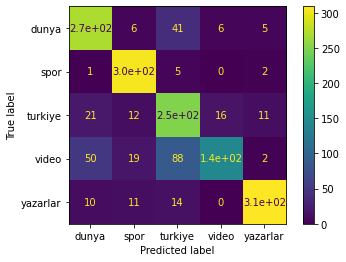

TF weighting


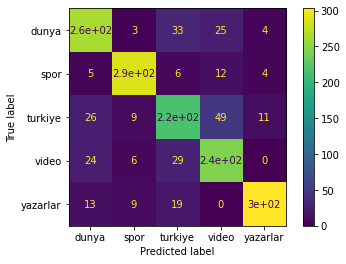

In [ ]:
# plot the confusion matrix
print("TF-idf weighting")
plot_confusion_matrix(logistic_model,X_validation_tfidf, y_validation)
plt.show()
print("TF weighting")
plot_confusion_matrix(logistic_model,X_val_bow, y_validation)
plt.show()

### Hyperparameter Tuning for Logistic Regression

In [ ]:
param_grid_ = {'C': [1e-5, 1e-3, 1e-1, 1e0, 1e1, 1e2], "penalty": ['l2'],'fit_intercept': [True,False]} # fit intercept parametresi ekle bi de 
tfidf_search = sklearn.model_selection.GridSearchCV(LogisticRegression(max_iter = 100000000), cv=5,
                                   param_grid=param_grid_)

# the penalty was: ['l2','l1','none'], but since setting the penalty to none and 'l1' would give UserWarning and decrease performance, I removed it from the grid seacrh list

In [ ]:
start = time.time()
tfidf_search.fit(X_train_tfidf, y_train)
print(tfidf_search.best_score_)
print(tfidf_search.best_params_)
end = time.time()
print(end - start)

0.857
{'C': 0.001, 'fit_intercept': True, 'penalty': 'l2'}
6205.4023106098175


### Naive Bayes

In [ ]:
#Build the naive bayes model
naive_model = MultinomialNB()
# Train the model using the training data
naive_model.fit(X_train_tfidf, y_train)

predicted_categories = naive_model.predict(X_validation_tfidf)
print("*********************TF-idf weighting****************")
print("The validation accuracy is {}".format(accuracy_score(y_validation,predicted_categories)))
print(classification_report(y_validation,predicted_categories))
print("***********************Bag of words (TF) weighting*********************")
naive_model.fit(X_tr_bow, y_train)
predicted_categories = naive_model.predict(X_val_bow)
print(classification_report(y_validation,predicted_categories))

*********************TF-idf weighting****************
The validation accuracy is 0.8
              precision    recall  f1-score   support

       dunya       0.80      0.87      0.84       329
        spor       0.89      0.92      0.90       313
     turkiye       0.71      0.64      0.67       311
       video       0.67      0.61      0.64       303
    yazarlar       0.89      0.93      0.91       344

    accuracy                           0.80      1600
   macro avg       0.79      0.80      0.79      1600
weighted avg       0.79      0.80      0.80      1600

***********************Bag of words (TF) weighting*********************
              precision    recall  f1-score   support

       dunya       0.79      0.86      0.83       329
        spor       0.88      0.93      0.91       313
     turkiye       0.68      0.65      0.66       311
       video       0.68      0.57      0.62       303
    yazarlar       0.90      0.93      0.91       344

    accuracy                

TF-idf weighting


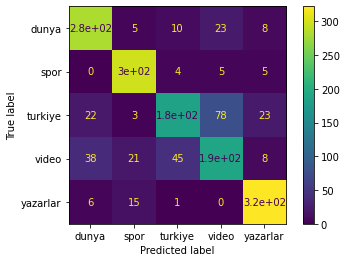

tf weighting


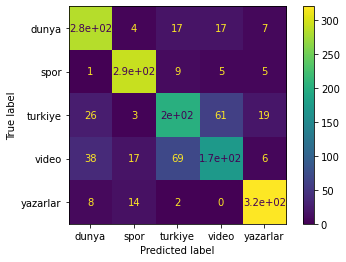

In [ ]:
# plot the confusion matrix
print("TF-idf weighting")
plot_confusion_matrix(naive_model,X_validation_tfidf, y_validation)
plt.show()
print("tf weighting")
plot_confusion_matrix(naive_model,X_val_bow, y_validation)
plt.show()

### Hyperparameter Tuning for Naive Bayes

In [ ]:
param_grid_ = {'alpha': [0.1,0.5,1.0,2.0,10.0], "fit_prior": [True,False]}
multinomial_nb_grid  = sklearn.model_selection.GridSearchCV(MultinomialNB(), cv=5,param_grid=param_grid_)

In [ ]:
start = time.time()
multinomial_nb_grid.fit(X_train_tfidf, y_train)
print(multinomial_nb_grid.best_score_)
print(multinomial_nb_grid.best_params_)
end = time.time()
print(end - start)

0.791625
{'alpha': 2.0, 'fit_prior': False}
4.963773250579834


### Testing the model's performance

In [ ]:
test_data['text'] = test_data['text'].apply(lambda x: preprocessText(x))

In [ ]:
bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False) #
X_tr_bow = bow_transform.fit_transform(train_data['text'])
X_test_bow = bow_transform.transform(test_data['text'])

In [ ]:
y_train = train_data['label']
y_test  = test_data['label']

In [ ]:
tfidf_transform = text.TfidfTransformer(norm=None) 
X_train_tfidf = tfidf_transform.fit_transform(X_tr_bow)
X_test_tfidf = tfidf_transform.transform(X_test_bow)

### Logistic Regression Test Set Performance

In [ ]:
logistic_model = LogisticRegression(C = 0.001, max_iter = 1000000).fit(X_train_tfidf, y_train)
# evaluate logistic regression test set performance
predicted_categories = logistic_model.predict(X_test_tfidf)
print("*********************TF-idf weighting****************")
print("The test accuracy is {}".format(accuracy_score(y_test,predicted_categories)))
print(classification_report(y_test,predicted_categories))
print("*********************Bag of words (TF) weighting****************")
logistic_model = LogisticRegression(C = 0.001, max_iter = 1000000).fit(X_tr_bow, y_train)
predicted_categories = logistic_model.predict(X_test_bow)
print(classification_report(y_test,predicted_categories))

*********************TF-idf weighting****************
The test accuracy is 0.8545
              precision    recall  f1-score   support

       dunya       0.84      0.83      0.84       395
        spor       0.96      0.92      0.94       384
     turkiye       0.80      0.72      0.76       421
       video       0.76      0.87      0.81       408
    yazarlar       0.94      0.95      0.94       392

    accuracy                           0.85      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.85      0.85      2000

*********************Bag of words (TF) weighting****************
              precision    recall  f1-score   support

       dunya       0.82      0.83      0.82       395
        spor       0.96      0.89      0.92       384
     turkiye       0.80      0.68      0.73       421
       video       0.72      0.87      0.79       408
    yazarlar       0.93      0.93      0.93       392

    accuracy                          

TF-idf weighting


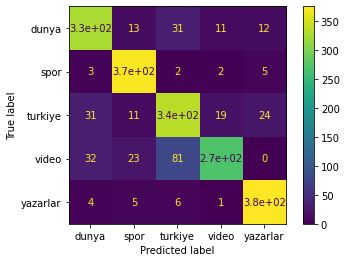

TF weighting


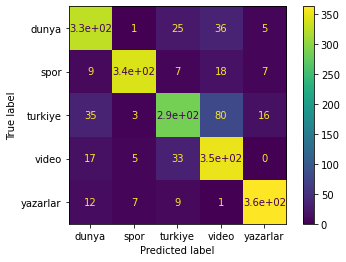

In [ ]:
print("TF-idf weighting")
plot_confusion_matrix(logistic_model,X_test_tfidf, y_test)
plt.show()
print("TF weighting")
plot_confusion_matrix(logistic_model,X_test_bow, y_test)
plt.show()

### Naive Bayes Test Set Performance

In [ ]:
# evaluate naive bayes test set performance
naive_model = MultinomialNB(alpha = 2.0).fit(X_train_tfidf, y_train)
predicted_categories = naive_model.predict(X_test_tfidf)
print("*********************TF-idf weighting****************")
print("The accuracy is {}".format(accuracy_score(y_test,predicted_categories)))
print(classification_report(y_test,predicted_categories))
print("*********************TF weighting****************")
naive_model = MultinomialNB().fit(X_tr_bow, y_train)
predicted_categories = naive_model.predict(X_test_bow)
print(classification_report(y_test,predicted_categories))

*********************TF-idf weighting****************
The accuracy is 0.782
              precision    recall  f1-score   support

       dunya       0.79      0.83      0.81       395
        spor       0.90      0.93      0.92       384
     turkiye       0.67      0.63      0.65       421
       video       0.67      0.58      0.62       408
    yazarlar       0.85      0.96      0.90       392

    accuracy                           0.78      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.77      0.78      0.78      2000

*********************TF weighting****************
              precision    recall  f1-score   support

       dunya       0.79      0.80      0.79       395
        spor       0.90      0.94      0.92       384
     turkiye       0.66      0.64      0.65       421
       video       0.66      0.56      0.61       408
    yazarlar       0.86      0.96      0.91       392

    accuracy                           0.78      2000
   ma

TF-idf weighting


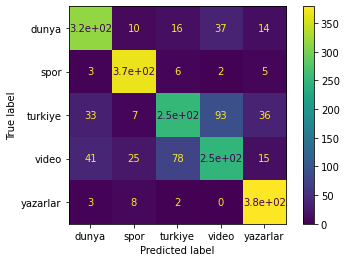

TF weighting


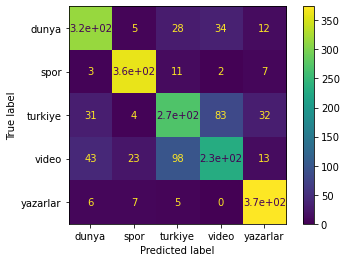

In [ ]:
# plot the confusion matrix
print("TF-idf weighting")
plot_confusion_matrix(naive_model,X_test_tfidf, y_test)
plt.show()
print("TF weighting")
plot_confusion_matrix(naive_model,X_test_bow, y_test)
plt.show()